In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
from time import perf_counter
import xgboost as xgb
from joblib import Parallel, delayed
from numpy import linalg as LA
import pandas as pd

#import src.utils.preprocess as pre
import preprocess as pre
from tst import Transformer, Transformer_Sigmoid
# from tst import Transformer_with_sst
import os
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.neural_network import MLPRegressor
import torch

In [3]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [4]:
import random
random.seed(20)
torch.manual_seed(422) #423
np.random.seed(10)


In [5]:
plt.rcParams.update({'font.size': 14})

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_data = train_data.to(device)

In [7]:
device

device(type='cuda')

# Download data

In [8]:
%%time
(X_train, y_train), (X_test, y_test) = pre.create_dataset(n_comp=20,n_sst_comp=20,target_variable='tmp2m')

CPU times: user 2.78 s, sys: 9.94 s, total: 12.7 s
Wall time: 16.6 s


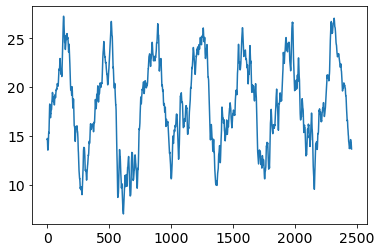

In [9]:
plt.plot(y_test[:, 509])

In [10]:
# choose one location
y_train = y_train[:,509].reshape((-1,1))
y_test = y_test[:,509].reshape((-1,1))

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9934, 40), (2456, 40), (9934, 1), (2456, 1))

In [12]:
# normilize X
X_mins = np.amin(X_train,axis=0)
# y_min = np.amin(y_train,axis=0)
X_train = X_train - X_mins
X_test = X_test - X_mins
# y_train = y_train - y_min
# y_test = y_test - y_min
X_maxs = np.amax(X_train,axis=0)
# y_max = np.amax(y_train,axis=0)
X_train = X_train/X_maxs
X_test = X_test/X_maxs
# y_train = y_train/y_max
# y_test = y_test/y_max

In [13]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0.0, 1.0, -0.08301995004894765, 1.0356012691558016)

# Detrending and Retrending functions

In [14]:
def detrend(y_train, y_test):
    train_dates = pd.date_range(start='1/1/1985', periods=y_train.shape[0])
    test_dates = pd.date_range(start=train_dates[-1] + pd.DateOffset(1), periods= y_test.shape[0])

    df_y_train = pd.DataFrame(y_train, index=train_dates)
    df_y_test = pd.DataFrame(y_test, index=test_dates)
    df_y_test.index = [df_y_test.index.month.astype(str)+"-"+df_y_test.index.day.astype(str),df_y_test.index]

    training_day_month_combos = df_y_train.index.month.astype(str)+"-"+df_y_train.index.day.astype(str)

    df_y_test = df_y_test.sub(df_y_train.groupby(training_day_month_combos).mean(),level=0)
    df_y_train = df_y_train.sub(df_y_train.groupby([df_y_train.index.month,df_y_train.index.day]).transform('mean'))
    
    df_y_test = df_y_test.div(df_y_train.groupby(training_day_month_combos).std(),level=0)
    df_y_train = df_y_train.div(df_y_train.groupby([df_y_train.index.month,df_y_train.index.day]).transform('std'))

    df_y_test = df_y_test.reset_index(level=0, drop=True)

    y_train_detrend = df_y_train.to_numpy()
    y_test_detrend = df_y_test.to_numpy()
    
    return y_train_detrend, y_test_detrend

In [15]:
def retrend(y_train_detrend, y_test_detrend, orig_y_train):
    train_dates = pd.date_range(start='1/1/1985', periods=y_train_detrend.shape[0])
    test_dates = pd.date_range(start=train_dates[-1] + pd.DateOffset(1), periods= y_test_detrend.shape[0])

    df_y_train = pd.DataFrame(y_train_detrend, index=train_dates)
    df_y_orig = pd.DataFrame(orig_y_train, index=train_dates)
    df_y_test = pd.DataFrame(y_test_detrend, index=test_dates)
    df_y_test.index = [df_y_test.index.month.astype(str)+"-"+df_y_test.index.day.astype(str),df_y_test.index]

    training_day_month_combos = df_y_train.index.month.astype(str)+"-"+df_y_train.index.day.astype(str)

    df_y_test = df_y_test.mul(df_y_orig.groupby(training_day_month_combos).std(),level=0)
    df_y_train = df_y_train.mul(df_y_orig.groupby([df_y_train.index.month,df_y_train.index.day]).transform('std'))

    df_y_test = df_y_test.add(df_y_orig.groupby(training_day_month_combos).mean(),level=0)
    df_y_train = df_y_train.add(df_y_orig.groupby([df_y_train.index.month,df_y_train.index.day]).transform('mean'))
    
    df_y_test = df_y_test.reset_index(level=0, drop=True)

    y_train_retrend = df_y_train.to_numpy()
    y_test_retrend = df_y_test.to_numpy()
    
    return y_train_retrend, y_test_retrend

# Proof my detrending code works

In [16]:
y_train_detrend, y_test_detrend = detrend(y_train, y_test)

In [17]:
y_train_detrend.shape, y_test_detrend.shape

((9934, 1), (2456, 1))

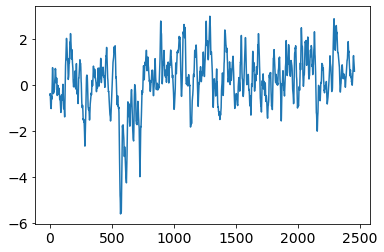

In [18]:
plt.plot(y_test_detrend)

Confirming that the applying the detrend function then the retrend function brings you back to the original.

In [19]:
(retrend(y_train_detrend, y_test_detrend, y_train)[0] - y_train).max()

3.552713678800501e-15

In [20]:
np.allclose(y_test, retrend(y_train_detrend, y_test_detrend, y_train)[1])

True

In [21]:
np.allclose(y_train, retrend(y_train_detrend, y_test_detrend, y_train)[0])

True

In [22]:
# normilize detrended data
y_min = np.amin(y_train_detrend, axis=0)
y_train_detrend = y_train_detrend - y_min
y_test_detrend = y_test_detrend - y_min

y_max = np.amax(y_train_detrend,axis=0)
y_train_detrend = y_train_detrend/y_max
y_test_detrend = y_test_detrend/y_max

In [23]:
print(np.max(y_train_detrend), np.min(y_train_detrend), np.max(y_test_detrend), np.min(y_test_detrend))

1.0 0.0 1.0120511795379619 -0.2382153668340343


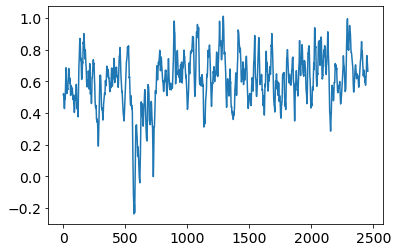

In [24]:
plt.plot(y_test_detrend)

In [25]:
# concatenate data to shift it for Transformer
X_total = np.concatenate((X_train, X_test), axis=0)
y_total = np.concatenate((y_train_detrend, y_test_detrend), axis=0)

data_total = np.concatenate((X_total[28:], y_total[:-28]), axis=1)

In [26]:
y_total_with_trend = np.concatenate((y_train, y_test), axis=0)

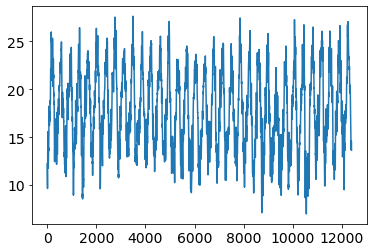

In [27]:
plt.plot(y_total_with_trend)

In [28]:
train_range = int(0.8*data_total.shape[0])
train_data_array = data_total[0:train_range]
test_data_array = data_total[train_range:]

In [29]:
train_data = torch.FloatTensor(train_data_array)
test_data = torch.FloatTensor(test_data_array)
# y_train = torch.FloatTensor(y_train_detrend)

### Transformer model 

In [30]:
def create_sequence(input_data, train_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    print('feature_size', feature_size)
    for i in range(L - train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window-1,feature_size-1] # get y_t+14
        # train_label = input_data[i + train_window + pred_window]
        seq.append((train_seq ,train_label))
        
    print('train_seq, train_label', train_seq.shape, train_label.shape)
    return seq

In [31]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data, train_window)

feature_size 41
train_seq, train_label torch.Size([90, 41]) torch.Size([])


In [32]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        
        self.seq_data = seq_data
        self.x = []
        self.y = []
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [33]:
BATCH_SIZE = 64
dataset_train = SeqDataset(train_seq)
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [34]:
train_window = 90
pred_window = 28
test_seq = create_sequence(test_data, train_window)

dataset_test = SeqDataset(test_seq)
dataloader_test = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

feature_size 41
train_seq, train_label torch.Size([90, 41]) torch.Size([])


In [35]:
d_input = 41 # From dataset
d_output = 1 # From dataset

attention_size = 90 #8 for old
LR = 1e-5 #1e-3
d_model = 64
q = 64 # Query size 8 for old
v = 64 # Value size 8 for old
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
# pe = 'original' # Positional encoding
chunk_mode = None
net = Transformer_Sigmoid(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=14, seq_length=90).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss()

In [36]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net)

2319132

[Epoch  97/100]: 100%|██████████| 9771/9771 [00:15<00:00, 613.26it/s, loss=0.00167]


[Epoch 100/100]: 100%|██████████| 9771/9771 [00:15<00:00, 612.93it/s, loss=0.00166]


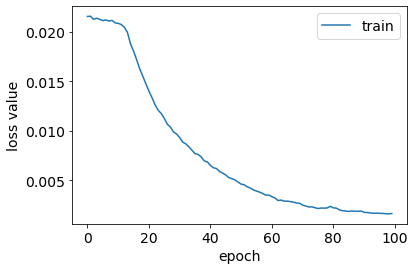

In [37]:
# train of OLD (small) Transformer, you can cut/skip it
EPOCHS = 100
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout) #myLoss(y_label.to(device), netout)
            #loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        if idx_epoch % 10 ==0 or idx_epoch == EPOCHS-1:
            pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
        
#         with torch.no_grad():
#             net.eval()
#             loss_val = 0
#             for idx_batch, (x, y_label) in enumerate(dataloader_test):
#                 y_label = y_label.view(-1,1)

#                 netout = net(x.to(device))
#                 loss_val += loss_function(y_label.to(device), netout).item()

#         hist_loss_val[idx_epoch] = loss_val / (idx_batch+1)
        pbar.set_postfix({'loss': hist_loss[idx_epoch]})
#         pbar.set_postfix({'loss': hist_loss[idx_epoch], 'val_loss': hist_loss_val[idx_epoch]})
#         net.train()
            
        
plt.plot(hist_loss, label='train')
plt.xlabel('epoch')
plt.ylabel('loss value')
# plt.plot(hist_loss_val, label='test')
# plt.xlabel('epoch')
# plt.ylabel('loss value')
plt.legend()

[Epoch  81/100]: 100%|██████████| 9771/9771 [00:20<00:00, 483.55it/s, loss=0.0017, val_loss=0.00229]


[Epoch 100/100]: 100%|██████████| 9771/9771 [00:20<00:00, 482.73it/s, loss=0.00162, val_loss=0.00293]


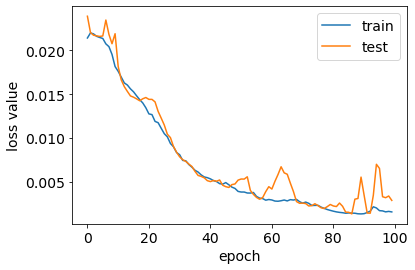

In [44]:
EPOCHS = 100
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout) #myLoss(y_label.to(device), netout)
            #loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        if idx_epoch % 10 ==0 or idx_epoch == EPOCHS-1:
            pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
        
        with torch.no_grad():
            net.eval()
            loss_val = 0
            for idx_batch, (x, y_label) in enumerate(dataloader_test):
                y_label = y_label.view(-1,1)

                netout = net(x.to(device))
                loss_val += loss_function(y_label.to(device), netout).item()

        hist_loss_val[idx_epoch] = loss_val / (idx_batch+1)
        pbar.set_postfix({'loss': hist_loss[idx_epoch], 'val_loss': hist_loss_val[idx_epoch]})
        net.train()
            
        
plt.plot(hist_loss, label='train')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.plot(hist_loss_val, label='test')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

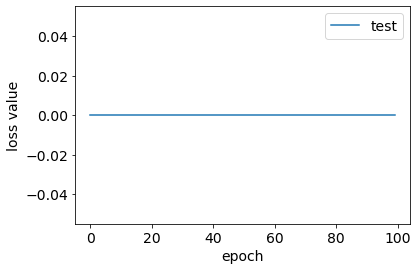

In [38]:
plt.plot(hist_loss_val,  label='test')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()

In [39]:
train_test_total = np.concatenate((train_data_array, test_data_array))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

100%|██████████| 12272/12272 [03:28<00:00, 58.77it/s]


In [40]:
y_all = np.concatenate((y_train_detrend, y_test_detrend))[:-28] # detrended version, normilized
print(y_all.shape)

(12362, 1)


In [41]:
y_all_with_trend = np.concatenate((y_train, y_test))[:-28] # a version with trend, no normalization
print(y_all_with_trend.shape)

(12362, 1)


In [42]:
test_size = y_test.shape[0]
target = 'tmp'

r-sq on train: 0.8328826404964061
r-sq on test: 0.8232915117705325
cosine_similarity on train: [[0.9957694]]
cosine_similarity on test: [[0.99341804]]


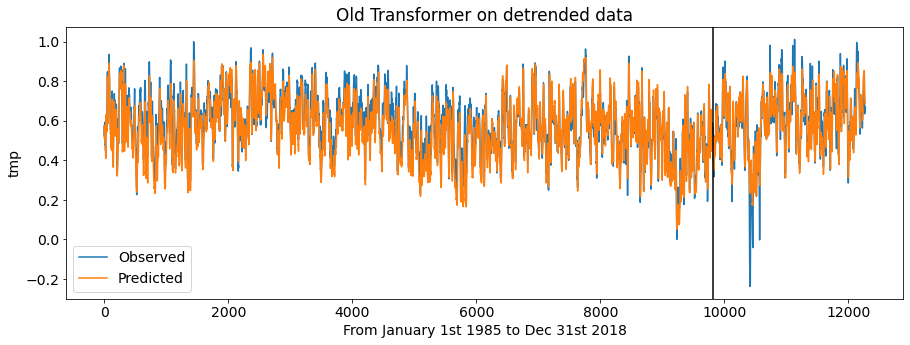

In [43]:
print('r-sq on train:', r2_score(y_all[train_window:-test_size], res[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window:-test_size].reshape((1,-1)), 
                                                       res[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  
                                                      res[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window:],label='Observed')
plt.plot(res[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Old Transformer on detrended data')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.8610348278310528
r-sq on test: 0.7034839095515741
cosine_similarity on train: [[0.99608831]]
cosine_similarity on test: [[0.98888265]]


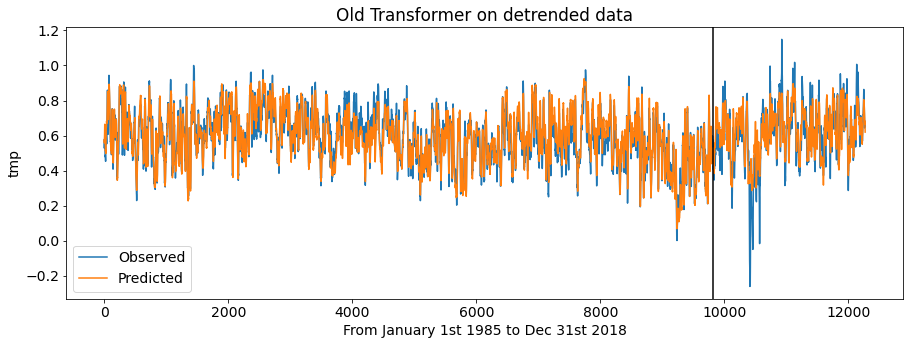

In [45]:
print('r-sq on train:', r2_score(y_all[train_window:-test_size], res[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window:-test_size].reshape((1,-1)), 
                                                       res[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  
                                                      res[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window:],label='Observed')
plt.plot(res[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Old Transformer on detrended data')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.8330168537757386
r-sq on test: 0.7945063902554269
cosine_similarity on train: [[0.99652932]]
cosine_similarity on test: [[0.99328043]]


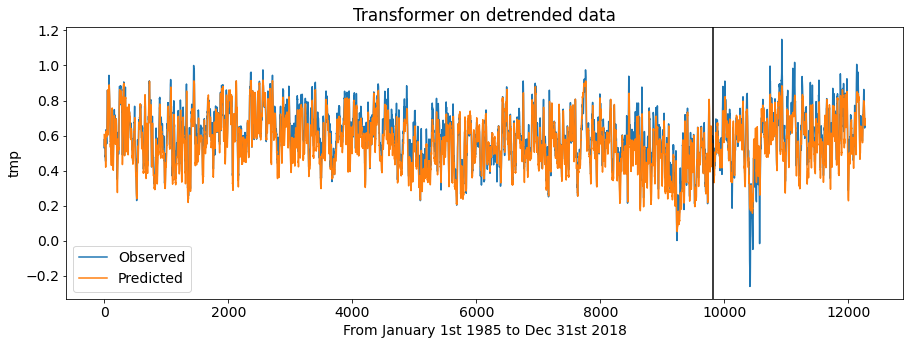

In [52]:
print('r-sq on train:', r2_score(y_all[train_window:-test_size], res[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window:-test_size].reshape((1,-1)), 
                                                       res[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  
                                                      res[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window:],label='Observed')
plt.plot(res[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on detrended data')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.6240431848660268
r-sq on test: 0.6176651761102205
cosine_similarity on train: [[0.99316214]]
cosine_similarity on test: [[0.98930029]]


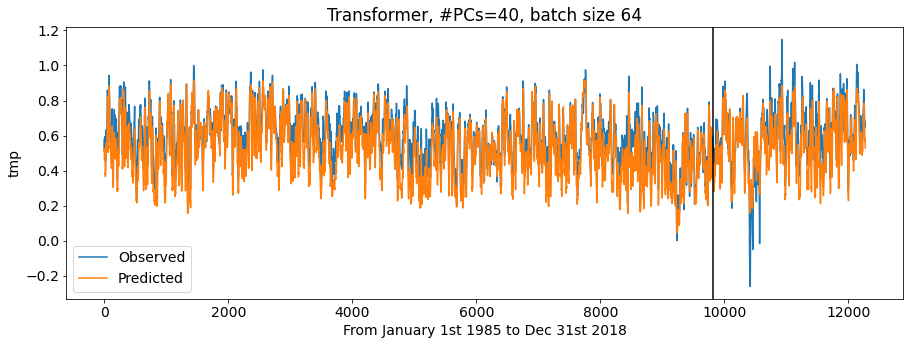

In [43]:
print('r-sq on train:', r2_score(y_all[train_window:-test_size], res[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window:-test_size].reshape((1,-1)), 
                                                       res[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  
                                                      res[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window:],label='Observed')
plt.plot(res[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer, #PCs=40, batch size 64')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

In [44]:
y_all[train_window:-test_size].shape, y_all[-test_size:].shape

((9816, 1), (2456, 1))

In [46]:
# renormilize
res_renorm = res*y_max + y_min

y_all_renorm = y_all*y_max + y_min

r-sq on train: 0.8610348278310528
r-sq on test: 0.703483909551574
cosine_similarity on train: [[0.93373666]]
cosine_similarity on test: [[0.84421545]]


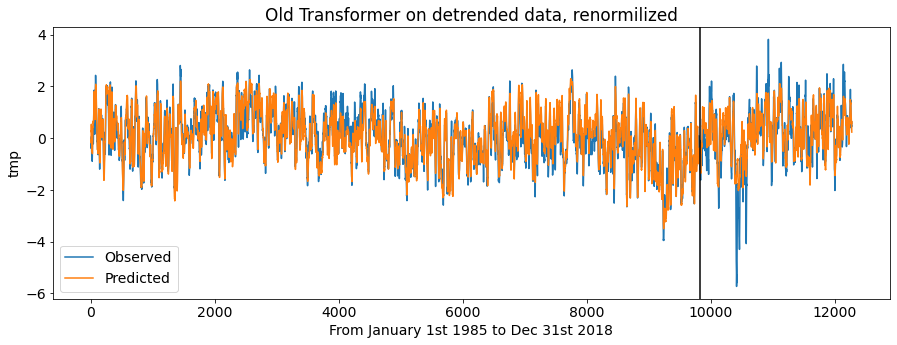

In [47]:
print('r-sq on train:', r2_score(y_all_renorm[train_window:-test_size], res_renorm[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all_renorm[-test_size:],  res_renorm[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all_renorm[train_window:-test_size].reshape((1,-1)), 
                                                       res_renorm[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all_renorm[-test_size:].reshape((1,-1)),  
                                                      res_renorm[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all_renorm[train_window:],label='Observed')
plt.plot(res_renorm[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Old Transformer on detrended data, renormilized')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.8330168537757386
r-sq on test: 0.7945063902554269
cosine_similarity on train: [[0.92484048]]
cosine_similarity on test: [[0.89532215]]


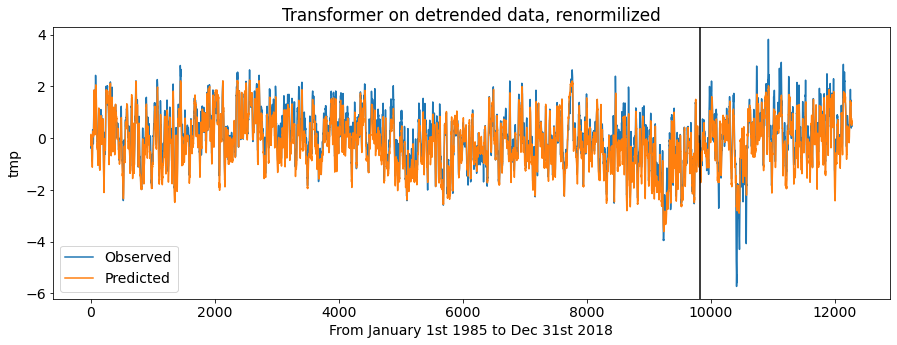

In [54]:
print('r-sq on train:', r2_score(y_all_renorm[train_window:-test_size], res_renorm[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all_renorm[-test_size:],  res_renorm[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all_renorm[train_window:-test_size].reshape((1,-1)), 
                                                       res_renorm[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all_renorm[-test_size:].reshape((1,-1)),  
                                                      res_renorm[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all_renorm[train_window:],label='Observed')
plt.plot(res_renorm[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on detrended data, renormilized')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

In [84]:
y_total_with_trend[:-28][train_window:-test_size].shape

(9816, 1)

In [88]:
res_renorm.shape, y_total_with_trend.shape

((12362,), (12390, 1))

In [139]:
a = np.array([1, 2, 3, 4, 5])
a[:-2]

array([1, 2, 3])

In [143]:
res_renorm[:-test_size+28].shape, res_renorm[-test_size:].shape

((9934,), (2456,))

In [146]:
y_total_with_trend[:-28][:-test_size+28].shape

(9934, 1)

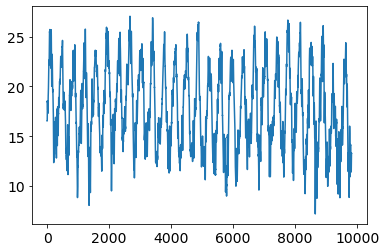

In [48]:
# add trend back
# ? do we need take y_total_with_trend[:-28] since we already took it
y_train_pred_retrend, y_test_pred_retrend = retrend(res_renorm[train_window:-test_size], res_renorm[-test_size:], 
        y_total_with_trend[:-28][train_window:-test_size])

# y_train_pred_retrend, y_test_pred_retrend = retrend(res_renorm[:-test_size+28], res_renorm[-test_size:], 
#         y_total_with_trend[:-28][:-test_size+28])

plt.plot(y_train_pred_retrend)

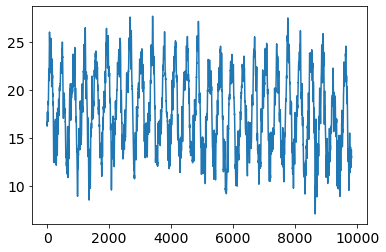

In [49]:
plt.plot(y_total_with_trend[:-28][train_window:-test_size])

In [161]:
y_all_with_trend[train_window:-test_size].shape, y_train_pred_retrend[:-118].shape

((9816, 1), (9698, 1))

r-sq on train: 0.9762418689306537
r-sq on test: 0.9453583042603032


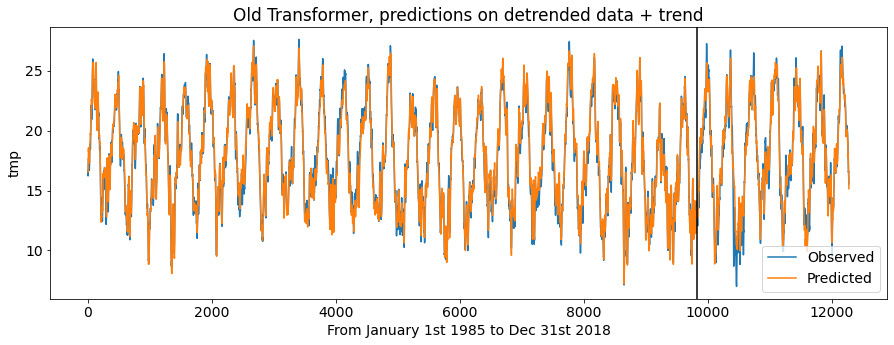

In [50]:
print('r-sq on train:', r2_score(y_all_with_trend[train_window:-test_size], 
                                 y_train_pred_retrend))
print('r-sq on test:', r2_score(y_all_with_trend[-test_size:],  
                                y_test_pred_retrend))
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[train_window:],label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend)),label='Predicted')
# plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Old Transformer, predictions on detrended data + trend')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.97235394673835
r-sq on test: 0.9616098013334512


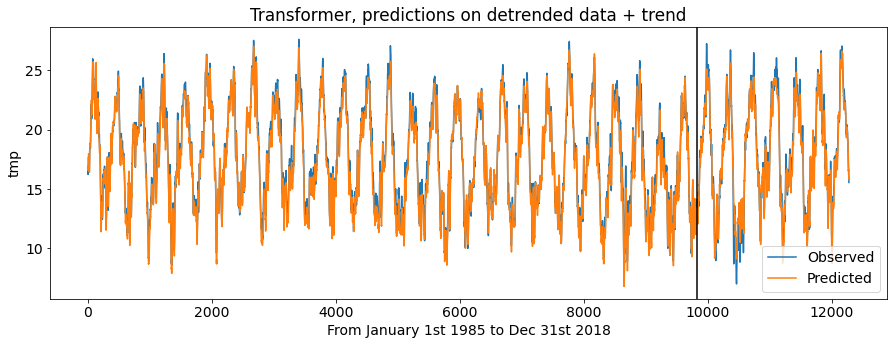

In [162]:
print('r-sq on train:', r2_score(y_all_with_trend[train_window:-test_size], 
                                 y_train_pred_retrend))
print('r-sq on test:', r2_score(y_all_with_trend[-test_size:],  
                                y_test_pred_retrend))
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[train_window:],label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend)),label='Predicted')
# plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer, predictions on detrended data + trend')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.97235394673835
r-sq on test: 0.9616098013334512


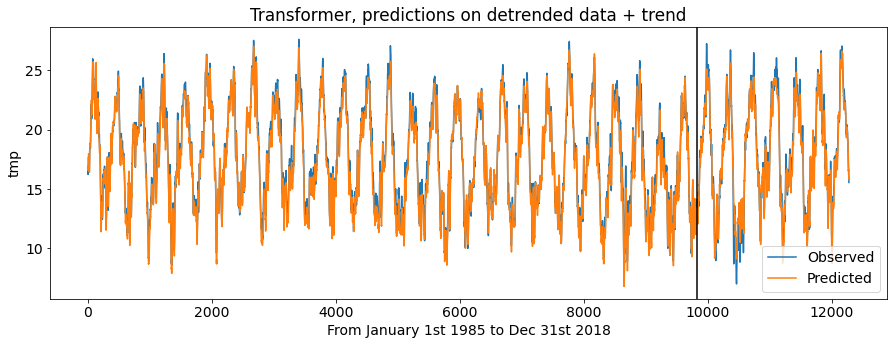

In [57]:
print('r-sq on train:', r2_score(y_all_with_trend[train_window:-test_size], 
                                 y_train_pred_retrend))
print('r-sq on test:', r2_score(y_all_with_trend[-test_size:],  
                                y_test_pred_retrend))
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[train_window:],label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend)),label='Predicted')
# plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer, predictions on detrended data + trend')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.9377952499066384
r-sq on test: 0.9268049391976035


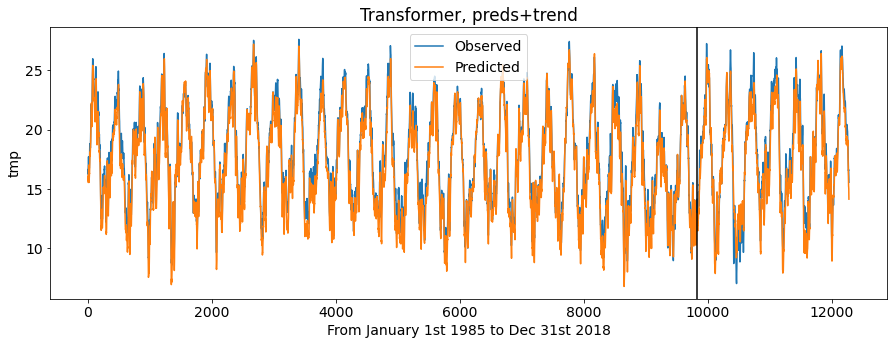

In [49]:
print('r-sq on train:', r2_score(y_all_with_trend[train_window:-test_size], 
                                 y_train_pred_retrend))
print('r-sq on test:', r2_score(y_all_with_trend[-test_size:],  
                                y_test_pred_retrend))
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[train_window:],label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend)),label='Predicted')
# plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer, preds+trend')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

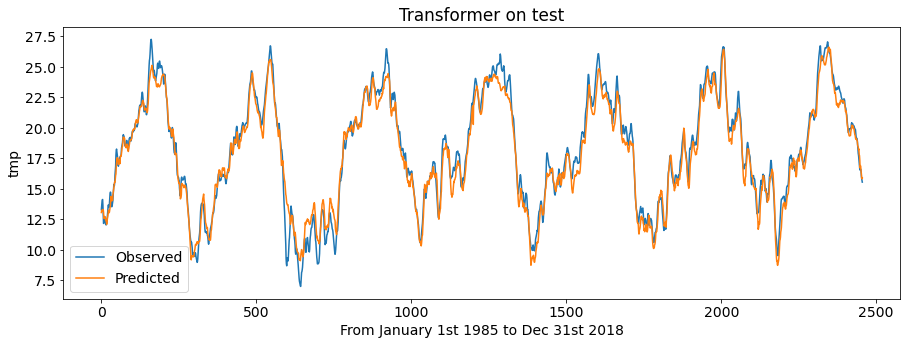

In [58]:
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[-test_size:],label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[-test_size:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test');

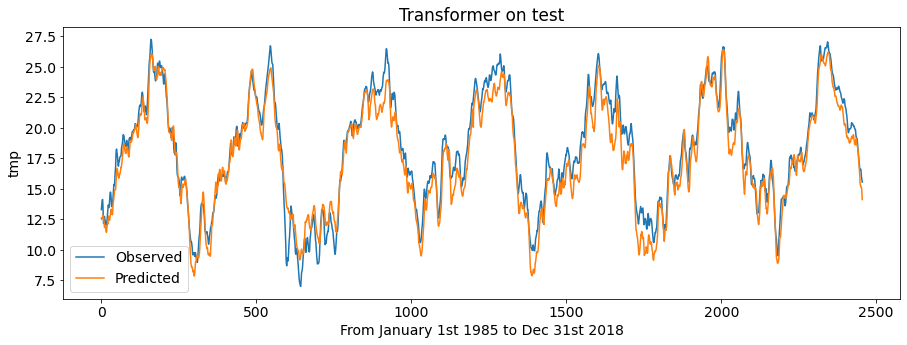

In [50]:
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[-test_size:],label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[-test_size:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test');

In [60]:
res_renorm[train_window:-test_size].shape, res_renorm[-test_size:].shape

((9816,), (2456,))

### Zeros + trend

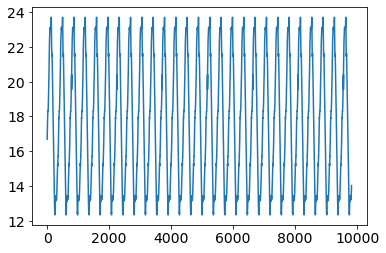

In [129]:
y_train_pred_0, y_test_pred_0 = retrend(np.zeros((9816)), np.zeros((2456)),
        y_total_with_trend[:-28][train_window:-test_size])

plt.plot(retrend(np.zeros((9816)), np.zeros((2456)), 
        y_total_with_trend[:-28][train_window:-test_size])[0])

In [130]:
y_all_with_trend[train_window:-test_size].shape, y_train_pred_0.shape

((9816, 1), (9816, 1))

r-sq on train: 0.828279869601373
r-sq on test: 0.8079421975797815


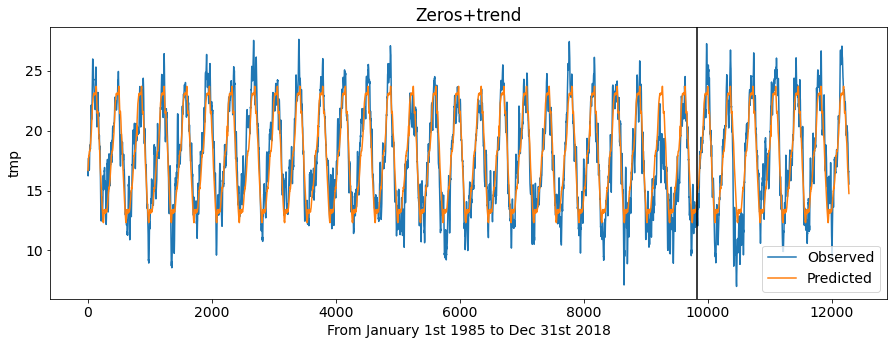

In [131]:
print('r-sq on train:', r2_score(y_all_with_trend[train_window:-test_size], 
                                 y_train_pred_0))
print('r-sq on test:', r2_score(y_all_with_trend[-test_size:],  
                                y_test_pred_0))
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[train_window:],label='Observed')
plt.plot(np.concatenate((y_train_pred_0, y_test_pred_0)),label='Predicted')
# plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Zeros+trend')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

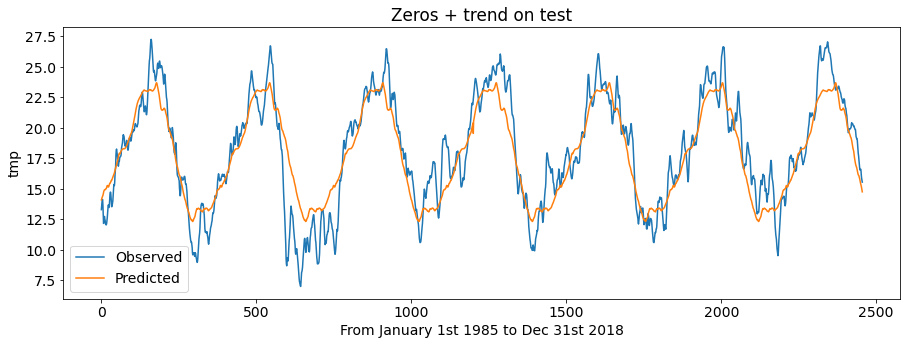

In [132]:
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[-test_size:],label='Observed')
plt.plot(np.concatenate((y_train_pred_0, y_test_pred_0))[-test_size:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Zeros + trend on test');

### XGBoost 

In [62]:
class XGBoost():
    def __init__(self, num_models=3274, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100,
                 n_jobs=16, nthread=None, objective='reg:squarederror',
                 random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, seed=None, silent=True, subsample=1):


        """ Initilize a list of XGBoost 
        """
        super().__init__()    

        self.models = [xgb.XGBRegressor(objective=objective, max_depth=max_depth, learning_rate=learning_rate,
                                        colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma,
                                        base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
                                        max_delta_step=max_delta_step, min_child_weight=min_child_weight, missing=missing,
                                        n_jobs=1, nthread=nthread, random_state=random_state,
                                        reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                        scale_pos_weight=scale_pos_weight, seed=seed,
                                        silent=silent, subsample=subsample, tree_method='gpu_hist', n_gpus=1) for i in range(num_models)]
        self.n_jobs = n_jobs
        self.num_models = num_models



    def fit(self, X, y):

        """ fit XGBoost model at each location
        """
        #print(X.shape, y.shape)
        #self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y[:, loc]) for loc in range(self.num_models))# 197x2x num_estimators
        self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y) for loc in range(self.num_models))# 197x2x num_estimators



        return self.models
  

    def fit_cv(self, train_x, train_y, val_x, val_y):

        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        history = np.asarray(Parallel(n_jobs=self.n_jobs)(delayed(self.fit_single_output)
                                                          (self.models[loc], train_x, train_y[:, loc], val_x, val_y[:, loc])
                                                          for loc in range(self.num_models)))# 197x2x num_estimators

        return history


    def predict(self, X):
        """ For XGBoost model at each location, make prediction
        """
        pred_y = np.asarray((Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].predict)(X) for loc in range(self.num_models))))# 197x2x num_estimators


        return pred_y.T


    def fit_single_output(self, mdl, train_x, train_y, test_x, test_y):
        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        eval_set = [(train_x, train_y), (test_x, test_y)]
        eval_metric = ['rmse']

        mdl.fit(train_x, train_y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


        train_eval = mdl.evals_result()['validation_0']['rmse']
        test_eval = mdl.evals_result()['validation_1']['rmse']


        return train_eval, test_eval

In [64]:
mdl = XGBoost(num_models=1, n_jobs=1)
mdl.fit(X_train, y_train_detrend)
pred_train = mdl.predict(X_train)
pred_test = mdl.predict(X_test)

[08:22:54] WARNING: ../include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[08:22:54] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:22:54] WARNING: ../include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


r-sq on train: 0.4770316522626996
r-sq on test: -0.03322410835642331
cosine_similarity on train: [[0.97504361]]
cosine_similarity on test: [[0.97259845]]


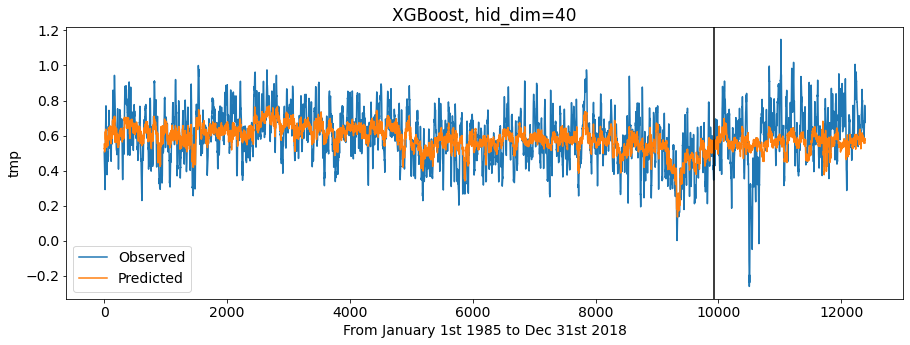

In [68]:
print('r-sq on train:', r2_score(y_train_detrend, pred_train))
print('r-sq on test:', r2_score(y_test_detrend,  pred_test))
print('cosine_similarity on train:', cosine_similarity(y_train.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train_detrend, y_test_detrend)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost, hid_dim=40')
plt.axvline(x=np.concatenate((y_train_detrend, y_test_detrend)).shape[0]- test_size,c='black');

In [67]:
y_train_pred_retrend, y_test_pred_retrend = retrend(pred_train, pred_test,  y_train)

r-sq on train: 0.7861499343863387
r-sq on test: 0.7923582326739874
cosine_similarity on train: [[0.99599978]]
cosine_similarity on test: [[0.99430928]]


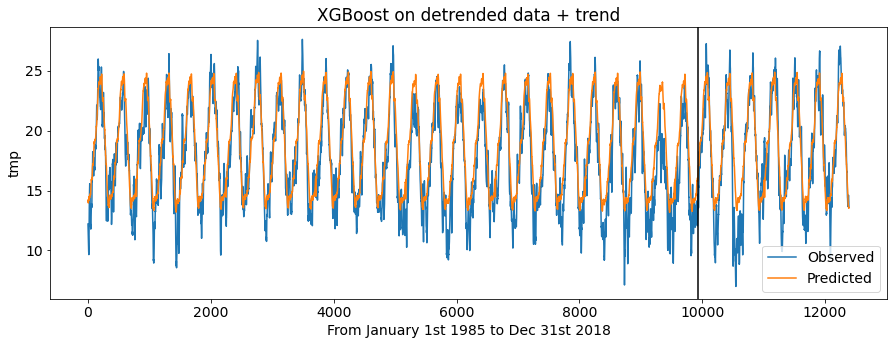

In [72]:
print('r-sq on train:', r2_score(y_train, y_train_pred_retrend))
print('r-sq on test:', r2_score(y_test,  y_test_pred_retrend))
print('cosine_similarity on train:', cosine_similarity(y_train.reshape((1,-1)), y_train_pred_retrend.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test.reshape((1,-1)),  y_test_pred_retrend.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)),label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on detrended data + trend')
plt.axvline(x=np.concatenate((y_train_detrend, y_test_detrend)).shape[0]- test_size,c='black');

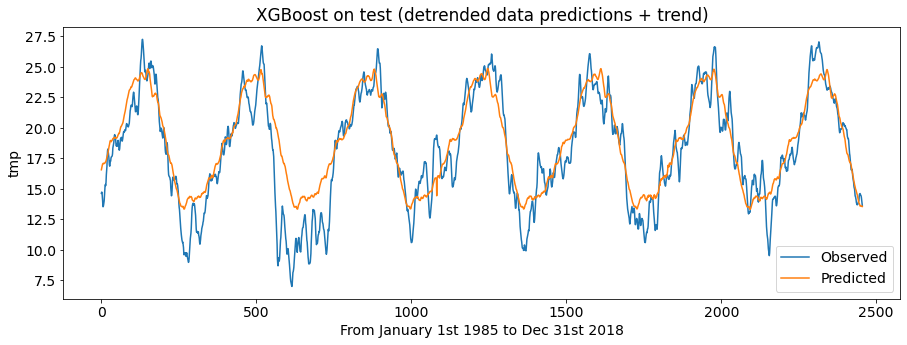

In [74]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(y_test_pred_retrend,label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on test (detrended data predictions + trend)');

# Multitask RF, with no detrending

In [101]:
%%time
clf = RandomForestRegressor(min_samples_leaf=25, max_features='sqrt', random_state=42, oob_score=True,
                           n_jobs=-1)

clf.fit(X_train, y_train)
clf.oob_score_

<timed exec>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 4.64 s, sys: 40.2 ms, total: 4.68 s
Wall time: 686 ms


0.8964351481936363

In [102]:
clf.score(X_test, y_test)

0.7801549948130404

In [103]:
clf.score(X_train, y_train)

0.9189128626966545

In [104]:
clf.score(X_test, y_test)

0.7801549948130404

### Proof the "score" method is the average of each location's R^2

In [28]:
r2_score(y_test,clf.predict(X_test))

0.123298240267118

In [29]:
r2s = []

predictions = clf.predict(X_test)

for i in range(y_test.shape[1]):
    r2s.append(r2_score(y_test[:,i], predictions[:,i]))


In [30]:
np.mean(r2s)

0.12329824026711796

# MT RF on detrended precip data

In [31]:
%%time
clf_dt = RandomForestRegressor(min_samples_leaf=25, max_features='sqrt', random_state=42, oob_score=True,
                           n_jobs=-1)

clf_dt.fit(X_train, y_train_detrend)
clf_dt.oob_score_

CPU times: user 8min 28s, sys: 20 s, total: 8min 48s
Wall time: 1min 9s


0.274950171193766

In [32]:
clf_dt.score(X_test, y_test_detrend)

-0.020614755915147394

In [33]:
clf_dt.score(X_train, y_train_detrend)

0.32900347567738836

CPU times: user 18 s, sys: 35.7 s, total: 53.8 s
Wall time: 21.5 s


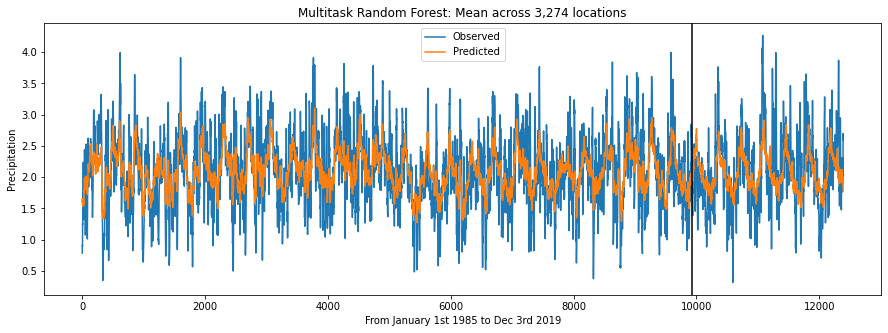

In [67]:
%%time
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train,y_test)).mean(axis=1),label='Observed')
plt.plot(np.concatenate(retrend(clf_dt.predict(X_train), clf_dt.predict(X_test), y_train)).mean(axis=1),
         label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 3rd 2019')
plt.ylabel('Precipitation')
plt.title('Multitask Random Forest: Mean across 3,274 locations')
plt.axvline(x=X_train.shape[0],c='black');

In [34]:
%%time
clf_dt_temp = RandomForestRegressor(min_samples_leaf=5, max_features='sqrt', random_state=42, oob_score=True,
                           n_jobs=-1)

clf_dt_temp.fit(X_train_temp, y_train_detrend_temp)
clf_dt_temp.oob_score_

CPU times: user 10min 30s, sys: 24.8 s, total: 10min 54s
Wall time: 1min 20s


0.7152471797153138

In [35]:
clf_dt_temp.score(X_test_temp, y_test_detrend_temp)

-0.09926727626046389

In [36]:
clf_dt_temp.score(X_train_temp, y_train_detrend_temp)

0.8427757537851404

# Multitask RF with 5 min samples leaf, not detrended

In [37]:
%%time
clf2 = RandomForestRegressor(min_samples_leaf=5, max_features='sqrt', random_state=42, oob_score=True,
                           n_jobs=-1)

clf2.fit(X_train, y_train)
clf2.oob_score_

CPU times: user 9min 46s, sys: 28.4 s, total: 10min 14s
Wall time: 1min 22s


0.6822612814207558

In [38]:
clf2.score(X_test, y_test)

0.11356583461338368

In [39]:
clf2.score(X_train, y_train)

0.8012998181757853

In [45]:
from sklearn.multioutput import MultiOutputRegressor

In [46]:
%%time
idx = np.random.randint(y_train.shape[1], size=100)

clf_multi = MultiOutputRegressor(RandomForestRegressor(min_samples_leaf=25, max_features='sqrt', random_state=42),
                           n_jobs=-1)

clf_multi.fit(X_train, y_train[:,idx])

CPU times: user 1.06 s, sys: 6.86 s, total: 7.92 s
Wall time: 41.1 s


MultiOutputRegressor(estimator=RandomForestRegressor(max_features='sqrt',
                                                     min_samples_leaf=25,
                                                     random_state=42),
                     n_jobs=-1)

In [47]:
clf_multi.score(X_test, y_test[:,idx])

0.11382675928741891

In [48]:
clf_multi.score(X_train, y_train[:,idx])

0.5797539936022358

### Warning: takes 20 minutes to run

In [74]:
%%time
idx = range(y_train.shape[1])
clf_multi_dt = MultiOutputRegressor(RandomForestRegressor(min_samples_leaf=25, max_features='sqrt', random_state=42, 
                                                          oob_score=True),
                           n_jobs=-1)

clf_multi_dt.fit(X_train, y_train_detrend[:,idx])

CPU times: user 33.9 s, sys: 17.5 s, total: 51.4 s
Wall time: 20min 13s


MultiOutputRegressor(estimator=RandomForestRegressor(max_features='sqrt',
                                                     min_samples_leaf=25,
                                                     oob_score=True,
                                                     random_state=42),
                     n_jobs=-1)

In [75]:
clf_multi_dt.score(X_test, y_test_detrend[:,idx])

-0.030406121740078094

In [76]:
clf_multi_dt.score(X_train, y_train_detrend[:,idx])

0.5118957866341053

In [77]:
np.mean([a.oob_score_ for a in clf_multi_dt.estimators_])

0.3920805796325392

### Warning: takes 60 minutes to run

In [78]:
%%time
clf_xgmulti_dt = MultiOutputRegressor(xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, n_estimators=100,
                 n_jobs=16, objective='reg:squarederror',
                 random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, seed=42, subsample=1), n_jobs=-1)

clf_xgmulti_dt.fit(X_train, y_train_detrend[:,idx])

CPU times: user 1min 16s, sys: 2.1 s, total: 1min 19s
Wall time: 1h 2min


MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=None,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=16,
                                            num_parallel_tree=None,
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scal

In [79]:
clf_xgmulti_dt.score(X_test, y_test_detrend[:,idx])

-0.06871674690371551

In [80]:
clf_xgmulti_dt.score(X_train, y_train_detrend[:,idx])

0.34571346801139424

In [40]:
X_all = np.concatenate((X_train, X_test))

In [41]:
in_test = np.concatenate((np.repeat(False, X_train.shape[0]), np.repeat(True, X_test.shape[0])))

In [42]:
clf_test = RandomForestClassifier(min_samples_leaf=5, max_features='sqrt', random_state=42, oob_score=True,
                           n_jobs=-1)
clf_test = clf_test.fit(X_all, in_test)

In [43]:
clf_test.feature_importances_

array([0.01748121, 0.00945209, 0.00294264, 0.00238027, 0.00680867,
       0.00303356, 0.00153707, 0.00309506, 0.02078701, 0.00207971,
       0.00702111, 0.00372109, 0.00242558, 0.00265556, 0.00262381,
       0.00182543, 0.00342736, 0.00441433, 0.02946164, 0.00378174,
       0.02934684, 0.03328975, 0.02637304, 0.05187677, 0.19892793,
       0.09012263, 0.03366358, 0.01898368, 0.0271067 , 0.03190559,
       0.02667829, 0.01942888, 0.03253262, 0.02170039, 0.0281976 ,
       0.0247403 , 0.06097748, 0.01727536, 0.02202494, 0.0738927 ])

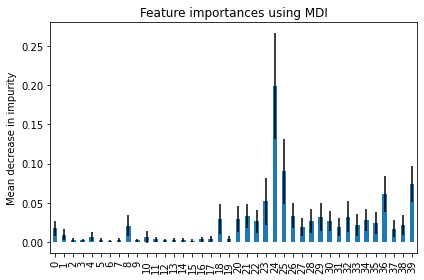

In [44]:
importances = clf_test.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in clf_test.estimators_], axis=0)

import pandas as pd
forest_importances = pd.Series(importances, index=range(40))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# ********End

In [62]:
xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100,
                 n_jobs=16, nthread=None, objective='reg:squarederror',
                 random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, seed=None, silent=True, subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=1, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, monotone_constraints=None,
             n_estimators=100, n_jobs=16, nthread=None, num_parallel_tree=None,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=True, subsample=1, tree_method=None,
             validate_parameters=None, verbosity=None)

In [ ]:
base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100,
                 n_jobs=16, nthread=None, objective='reg:squarederror',
                 random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, seed=None, silent=True, subsample=1

In [53]:
class XGBoost():
    def __init__(self, num_models=3274, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100,
                 n_jobs=16, nthread=None, objective='reg:squarederror',
                 random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, seed=None, silent=True, subsample=1):


        """ Initilize a list of XGBoost 
        """
        super().__init__()    

        self.models = [xgb.XGBRegressor(objective=objective, max_depth=max_depth, learning_rate=learning_rate,
                                        colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma,
                                        base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
                                        max_delta_step=max_delta_step, min_child_weight=min_child_weight, missing=missing,
                                        n_jobs=1, nthread=nthread, random_state=random_state,
                                        reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                        scale_pos_weight=scale_pos_weight, seed=seed,
                                        silent=silent, subsample=subsample, tree_method='gpu_hist', n_gpus=1) for i in range(num_models)]
        self.n_jobs = n_jobs
        self.num_models = num_models



    def fit(self, X, y):

        """ fit XGBoost model at each location
        """
        self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y[:, loc]) for loc in range(self.num_models))# 197x2x num_estimators


        return self.models
  

    def fit_cv(self, train_x, train_y, val_x, val_y):

        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        history = np.asarray(Parallel(n_jobs=self.n_jobs)(delayed(self.fit_single_output)
                                                          (self.models[loc], train_x, train_y[:, loc], val_x, val_y[:, loc])
                                                          for loc in range(self.num_models)))# 197x2x num_estimators

        return history


    def predict(self, X):
        """ For XGBoost model at each location, make prediction
        """
        pred_y = np.asarray((Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].predict)(X) for loc in range(self.num_models))))# 197x2x num_estimators


        return pred_y.T


    def fit_single_output(self, mdl, train_x, train_y, test_x, test_y):
        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        eval_set = [(train_x, train_y), (test_x, test_y)]
        eval_metric = ['rmse']

        mdl.fit(train_x, train_y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


        train_eval = mdl.evals_result()['validation_0']['rmse']
        test_eval = mdl.evals_result()['validation_1']['rmse']


        return train_eval, test_eval

In [59]:
%%time
mdl = XGBoost(num_models=1, n_jobs=1)

CPU times: user 80 µs, sys: 11 µs, total: 91 µs
Wall time: 97.8 µs


In [60]:
%%time
mdl.fit(X_train, y_train)

/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:24:16] WARNING: ../include/xgboost/generic_parameters.h:38: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[20:24:16] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 252 ms, sys: 117 ms, total: 369 ms
Wall time: 416 ms
[20:24:17] WARNING: ../include/xgboost/generic_parameters.h:38: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_gpus=1, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, silent=True, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)]

In [61]:
%%time
mdl.predict(X_test)

XGBoostError: [20:24:31] ../src/c_api/c_api_utils.h:161: Invalid missing value: null
Stack trace:
  [bt] (0) /home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9133f) [0x7f503eabd33f]
  [bt] (1) /home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9c811) [0x7f503eac8811]
  [bt] (2) /home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9cac0) [0x7f503eac8ac0]
  [bt] (3) /home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDense+0x225) [0x7f503eab0005]
  [bt] (4) /home-nfs/raphaelr/miniconda/lib/python3.8/lib-dynload/../../libffi.so.7(+0x69dd) [0x7f511656c9dd]
  [bt] (5) /home-nfs/raphaelr/miniconda/lib/python3.8/lib-dynload/../../libffi.so.7(+0x6067) [0x7f511656c067]
  [bt] (6) /home-nfs/raphaelr/miniconda/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x10da8) [0x7f5116582da8]
  [bt] (7) /home-nfs/raphaelr/miniconda/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x1108c) [0x7f511658308c]
  [bt] (8) /home-nfs/raphaelr/miniconda/bin/python3(_PyObject_MakeTpCall+0x22f) [0x56436a77785f]



In [54]:
%%time
mdl = XGBoost(num_models=1, n_jobs=1)
mdl.fit(X_train, y_train)
mdl.predict(X_test)

/home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:22:01] WARNING: ../include/xgboost/generic_parameters.h:38: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[20:22:01] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:22:04] WARNING: ../include/xgboost/generic_parameters.h:38: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


XGBoostError: [20:22:04] ../src/c_api/c_api_utils.h:161: Invalid missing value: null
Stack trace:
  [bt] (0) /home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9133f) [0x7f503eabd33f]
  [bt] (1) /home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9c811) [0x7f503eac8811]
  [bt] (2) /home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9cac0) [0x7f503eac8ac0]
  [bt] (3) /home-nfs/raphaelr/miniconda/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDense+0x225) [0x7f503eab0005]
  [bt] (4) /home-nfs/raphaelr/miniconda/lib/python3.8/lib-dynload/../../libffi.so.7(+0x69dd) [0x7f511656c9dd]
  [bt] (5) /home-nfs/raphaelr/miniconda/lib/python3.8/lib-dynload/../../libffi.so.7(+0x6067) [0x7f511656c067]
  [bt] (6) /home-nfs/raphaelr/miniconda/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x10da8) [0x7f5116582da8]
  [bt] (7) /home-nfs/raphaelr/miniconda/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x1108c) [0x7f511658308c]
  [bt] (8) /home-nfs/raphaelr/miniconda/bin/python3(_PyObject_MakeTpCall+0x22f) [0x56436a77785f]



In [43]:
1+1

2

In [14]:
y_test[:,509].shape

(2456,)

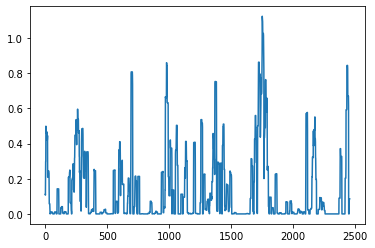

In [15]:
plt.plot(np.log10(y_test[:,509].reshape((-1,1)) + 1.0))

In [16]:
y_train = y_train[:,509].reshape((-1,1))
y_test = y_test[:,509].reshape((-1,1))

In [17]:
X_mins = np.amin(X_train,axis=0)
# y_min = np.amin(y_train,axis=0)
X_train = X_train - X_mins
X_test = X_test - X_mins
# y_train = y_train - y_min
# y_test = y_test - y_min
X_maxs = np.amax(X_train,axis=0)
# y_max = np.amax(y_train,axis=0)
X_train = X_train/X_maxs
X_test = X_test/X_maxs
# y_train = y_train/y_max
# y_test = y_test/y_max

In [18]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)


(0.0, 1.0, -0.08301995004894765, 1.0356012691558016)

In [19]:
y_train = np.log10(y_train + 1.0)
y_test = np.log10(y_test + 1.0) 

In [20]:
np.min(y_train)

0.0

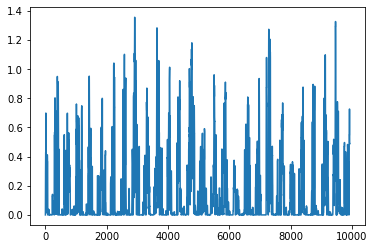

In [21]:
plt.plot(y_train)

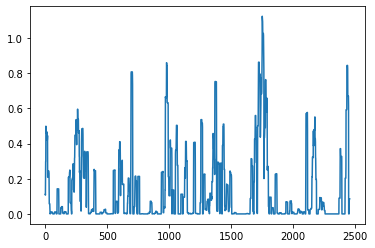

In [22]:
plt.plot(y_test )

In [23]:
y_train.shape

(9934, 1)

In [24]:
X_train.shape, X_test.shape

((9934, 40), (2456, 40))

In [25]:
X_total = np.concatenate((X_train,X_test),axis=0)
y_total = np.concatenate((y_train,y_test),axis=0)

In [26]:
data_total = np.concatenate((X_total[28:],y_total[:-28]),axis=1)

In [27]:
train_range = int(0.8*data_total.shape[0])
train_data_array = data_total[0:train_range]
test_data_array = data_total[train_range:]

In [28]:
train_data_array.shape, test_data_array.shape

((9889, 41), (2473, 41))

In [29]:
# train_data_array = np.concatenate((X_train, y_train), axis=1)
# test_data_array = np.concatenate((X_test, y_test), axis=1)

In [30]:
train_data = torch.FloatTensor(train_data_array)
y_train = torch.FloatTensor(y_train)

In [31]:
class SimpleDataset(Dataset):
    def __init__(self, data):
        self.samples = data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [32]:
def create_sequence(input_data, train_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    print('feature_size', feature_size)
    for i in range(L - train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window+pred_window-1,feature_size-1] # get y_t+14
#         train_label = input_data[i + train_window + pred_window]
        seq.append((train_seq ,train_label))
        
    print('train_seq, train_label', train_seq.shape, train_label.shape)
    return seq

In [33]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data, train_window)

feature_size 41
train_seq, train_label torch.Size([90, 41]) torch.Size([])


In [34]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        
        self.seq_data = seq_data
        self.x = []
        self.y = []
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [35]:
dataset_train = SeqDataset(train_seq)
dataloader_train = DataLoader(dataset_train,
                              batch_size=128,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [62]:
d_input = 41 # From dataset
d_output = 1 # From dataset

attention_size = 8
LR = 1e-5 #1e-3
d_model = 64
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
# pe = 'original' # Positional encoding
chunk_mode = None
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=2, seq_length=90).to(device)
# net = nn.Sequential(Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
#                   dropout=dropout, chunk_mode=chunk_mode, pe=pe),
#                     nn.Flatten(),
#                     nn.Linear(30, 1),
#                    ).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss() #OZELoss(alpha=0.3)

[Epoch  90/90]: 100%|██████████| 9771/9771 [00:07<00:00, 1289.54it/s, loss=0.0329]


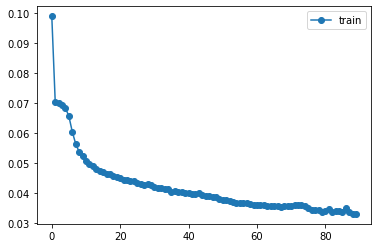

In [63]:
EPOCHS = 90
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        if idx_epoch % 10 ==0 or idx_epoch == EPOCHS-1:
            pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
#         hist_loss_val[idx_epoch] = val_loss

#         if val_loss < val_loss_best:
#             val_loss_best = val_loss
#             torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

In [64]:
train_test_total = np.concatenate((train_data_array, test_data_array))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

100%|██████████| 12272/12272 [03:22<00:00, 60.61it/s]


In [65]:
y_all = np.concatenate((y_train.cpu(), y_test))[:-28]

In [66]:
res.shape,y_all.shape

((12362,), (12362, 1))

In [67]:
test_size = y_test.shape[0]
target = 'precip'

r-sq on train: 0.0074811134312006144
r-sq on test: -0.31611666533339555
cosine_similarity on train: [[0.68428176]]
cosine_similarity on test: [[0.6485368]]


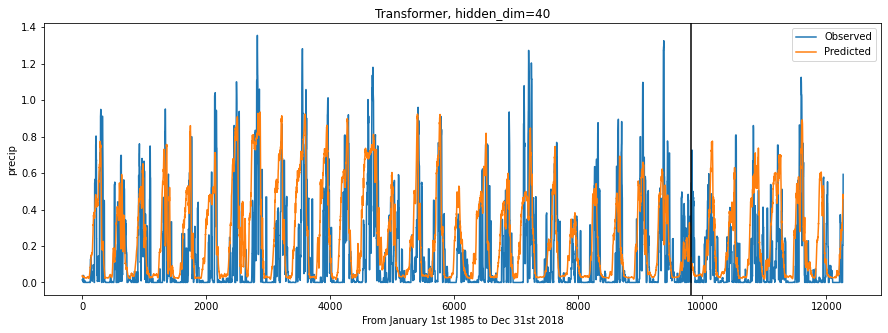

In [68]:
print('r-sq on train:', r2_score(y_all[train_window:-test_size], res[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window:-test_size].reshape((1,-1)), res[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window:],label='Observed')
plt.plot(res[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer, hidden_dim=40')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

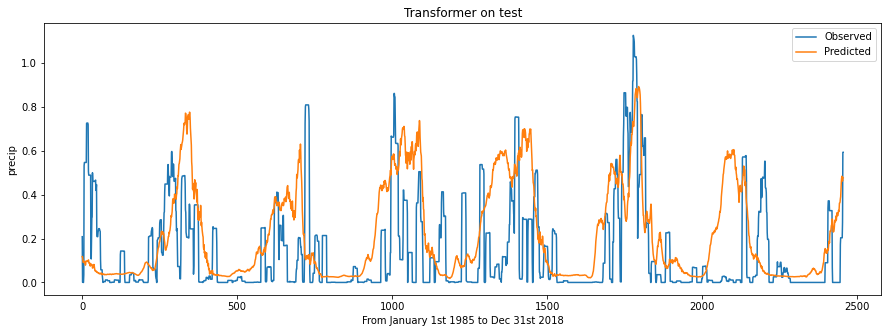

In [69]:
plt.figure(figsize=(15,5))
plt.plot(y_all[-test_size:],label='Observed')
plt.plot(res[-test_size:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test');

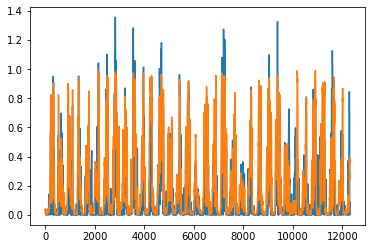

In [36]:
plt.plot(y_all[train_window:],label='Observed')
plt.plot(res[train_window:],label='Predicted')

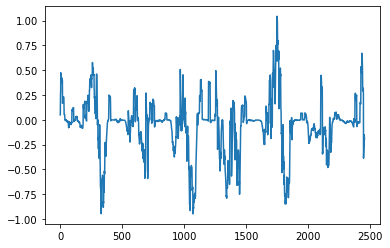

In [37]:
plt.plot(y_all[-test_size::].reshape(-1)-res[-test_size::])

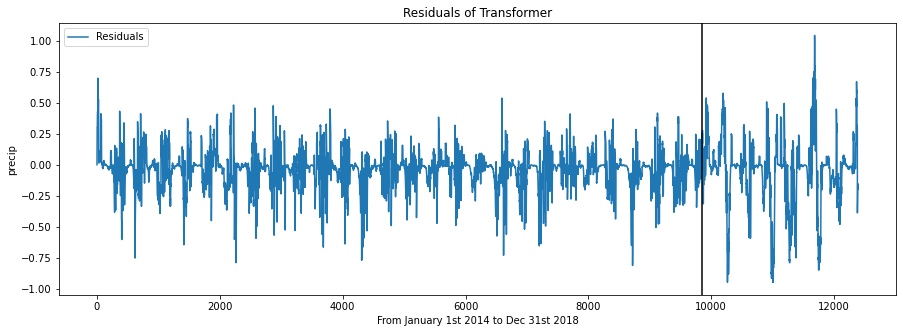

In [38]:
plt.figure(figsize=(15,5))
plt.plot(np.squeeze(y_all) - res ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer');
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

In [40]:
# (X_train, y_train), (X_test, y_test) = pre.create_dataset(n_comp=20,n_sst_comp=20,target_variable='precip')

In [41]:
# y_train = y_train[:,509].reshape((-1,1))
# y_test = y_test[:,509].reshape((-1,1))

In [42]:
# X_mins = np.amin(X_train,axis=0)
# y_min = np.amin(y_train,axis=0)
# X_train = X_train - X_mins
# X_test = X_test - X_mins
# y_train = y_train - y_min
# y_test = y_test - y_min
# X_maxs = np.amax(X_train,axis=0)
# y_max = np.amax(y_train,axis=0)
# X_train = X_train/X_maxs
# X_test = X_test/X_maxs
# y_train = y_train/y_max
# y_test = y_test/y_max

In [43]:
train_seq_x = np.array(X_train)
train_seq_y = np.array(y_train)

test_seq_x = np.array(X_test)
test_seq_y = np.array(y_test)

In [44]:
mdl = XGBoost(num_models=1, n_jobs=1)
mdl.fit(train_seq_x, train_seq_y)
pred_train = mdl.predict(train_seq_x)
pred_test = mdl.predict(test_seq_x)

[04:41:28] WARNING: ../include/xgboost/generic_parameters.h:35: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[04:41:28] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:41:33] WARNING: ../include/xgboost/generic_parameters.h:35: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


In [45]:
target = 'precip'

r-sq on train: 0.6344047974101068
r-sq on test: 0.10888462439513236
cosine_similarity on train: [[0.86702865]]
cosine_similarity on test: [[0.65087772]]


Text(0.5, 1.0, 'XGBoost, hid_dim=40')

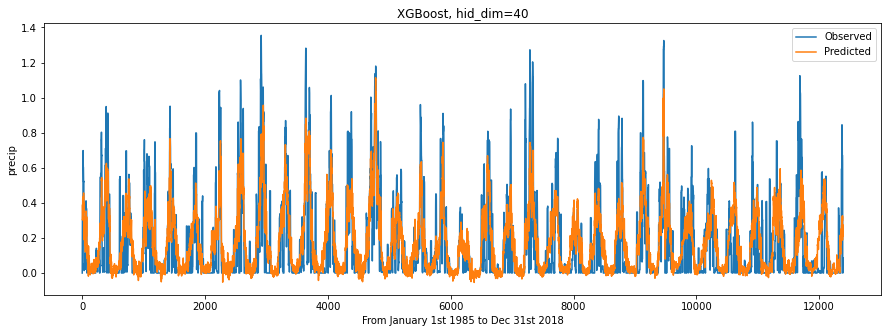

In [46]:
print('r-sq on train:', r2_score(y_train, pred_train))
print('r-sq on test:', r2_score(y_test,  pred_test))
print('cosine_similarity on train:', cosine_similarity(y_train.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost, hid_dim=40')
# plt.axvline(x=X.shape[0]- test_size,c='black');

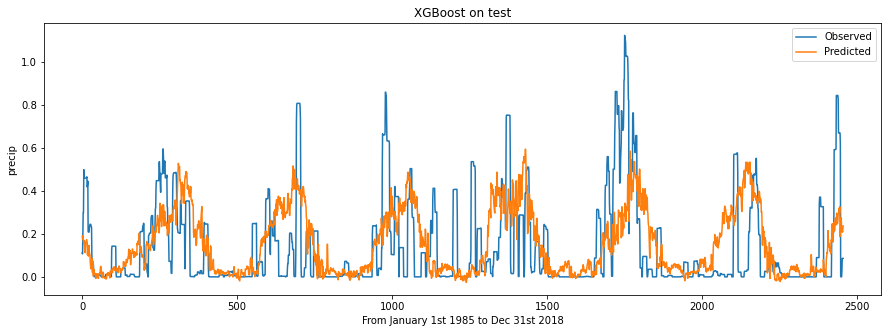

In [47]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(pred_test,label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on test');

In [48]:
mdl = MLPRegressor(hidden_layer_sizes=(1000,500,250,100,50),alpha=0.1)
mdl.fit(X_train, y_train.reshape((-1)))
pred_train = mdl.predict(X_train)
pred_test = mdl.predict(X_test)

r-sq on train: 0.7323037351299538
r-sq on test: -0.10339197909159581
cosine_similarity on train: [[0.91052115]]
cosine_similarity on test: [[0.52390575]]


Text(0.5, 1.0, 'MLP with layer sizes (1000,500,250,100,50) , hid_dim=40')

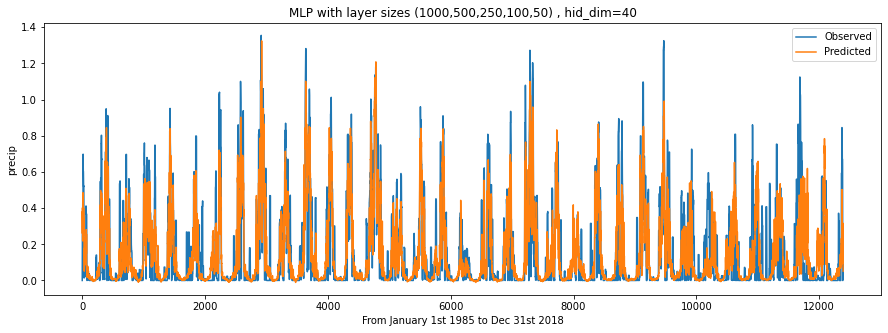

In [49]:
print('r-sq on train:', r2_score(y_train, pred_train))
print('r-sq on test:', r2_score(y_test,  pred_test))
print('cosine_similarity on train:', cosine_similarity(y_train.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('MLP with layer sizes (1000,500,250,100,50) , hid_dim=40')
# plt.axvline(x=X.shape[0]- test_size,c='black');

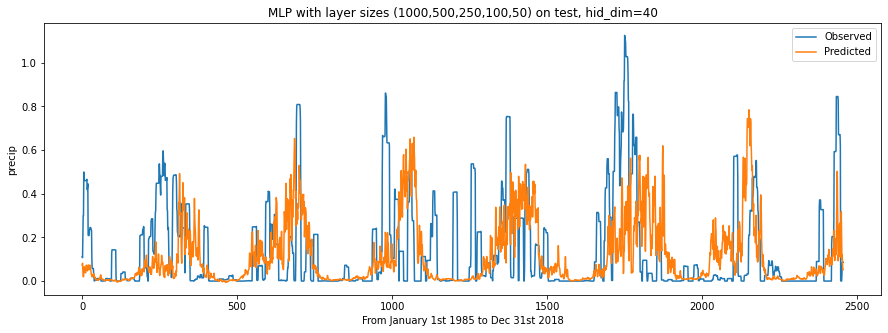

In [50]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(pred_test,label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('MLP with layer sizes (1000,500,250,100,50) on test, hid_dim=40');